In [20]:
import numpy as np
import pandas as pd


import json
import seaborn as sns
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfTransformer
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [2]:
train = open('train.json','r').read()
train_json = json.loads(train)
test = open('test.json','r').read()
test_json = json.loads(test)

In [3]:
len(train_json)

39774

In [4]:
df_dict = dict()
df_dict['id']=[]
df_dict['cuisine']=[]
df_dict['ingredient_list'] = []
train_df = pd.DataFrame(df_dict, dtype=np.int64)
test_df = train_df.copy()
print(train_df.head())

Empty DataFrame
Columns: [id, cuisine, ingredient_list]
Index: []


In [5]:
test_json[1]

{'id': 28583,
 'ingredients': ['sugar',
  'egg yolks',
  'corn starch',
  'cream of tartar',
  'bananas',
  'vanilla wafers',
  'milk',
  'vanilla extract',
  'toasted pecans',
  'egg whites',
  'light rum']}

In [6]:
train_json[0]

{'id': 10259,
 'cuisine': 'greek',
 'ingredients': ['romaine lettuce',
  'black olives',
  'grape tomatoes',
  'garlic',
  'pepper',
  'purple onion',
  'seasoning',
  'garbanzo beans',
  'feta cheese crumbles']}

In [7]:
i = 0
for curr_json in train_json:    
    ingredient_list = " ".join([re.sub('\s', "_", ingredient) for ingredient in curr_json['ingredients']])
    train_df.loc[i] = [curr_json['id'], curr_json['cuisine'], ingredient_list]
    i+=1
print(train_df.head())

      id      cuisine                                    ingredient_list
0  10259        greek  romaine_lettuce black_olives grape_tomatoes ga...
1  25693  southern_us  plain_flour ground_pepper salt tomatoes ground...
2  20130     filipino  eggs pepper salt mayonaise cooking_oil green_c...
3  22213       indian                     water vegetable_oil wheat salt
4  13162       indian  black_pepper shallots cornflour cayenne_pepper...


In [8]:
test_df.drop(['cuisine'], 1, inplace=True)
i = 0
for curr_json in test_json:    
    ingredient_list = " ".join([ re.sub('\s',"_",ingredient) for ingredient in curr_json['ingredients'] ])
    test_df.loc[i] =  [curr_json['id'], ingredient_list]
    i+=1
print(test_df.head())

      id                                    ingredient_list
0  18009  baking_powder eggs all-purpose_flour raisins m...
1  28583  sugar egg_yolks corn_starch cream_of_tartar ba...
2  41580  sausage_links fennel_bulb fronds olive_oil cub...
3  29752  meat_cuts file_powder smoked_sausage okra shri...
4  35687  ground_black_pepper salt sausage_casings leeks...


In [9]:
Y_train = train_df['cuisine']
train_df.drop('cuisine', 1, inplace=True)
print(Y_train.head())

0          greek
1    southern_us
2       filipino
3         indian
4         indian
Name: cuisine, dtype: object


In [10]:
print(train_df.shape, test_df.shape)

X = train_df.append(test_df)
print(X.shape)

ingredient_list = X['ingredient_list']
cv = CountVectorizer().fit(ingredient_list)
ingredient_list_count = cv.transform(ingredient_list)
print(ingredient_list_count.shape)

(39774, 2) (9944, 2)
(49718, 2)
(49718, 7299)


In [11]:
tfidf_transformer = TfidfTransformer().fit(ingredient_list_count)
ingredient_list_tfidf = tfidf_transformer.transform(ingredient_list_count)
print(ingredient_list_tfidf.shape)

(49718, 7299)


In [12]:
X_train = ingredient_list_tfidf[:39774]
X_test = ingredient_list_tfidf[39774:]

X_train, X_validation, Y_train, Y_validation = train_test_split(X_train,Y_train,test_size=0.2)
X_test_index = test_df['id']
print(f"train :{X_train.shape}{Y_train.shape}, test: {X_test.shape} index: {X_test_index.shape}, validation: {X_validation.shape}{Y_validation.shape}")

train :(31819, 7299)(31819,), test: (9944, 7299) index: (9944,), validation: (7955, 7299)(7955,)


In [13]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

In [14]:
len(set(Y_train.values))

20

In [16]:
classifiers = [
    KNeighborsClassifier(20),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB()]

In [17]:
len(classifiers) == len(names)

True

In [19]:
results = {}
for name, clf in zip(names, classifiers):

    clf.fit(X_train, Y_train)
    score = clf.score(X_validation, Y_validation)
#     print(name, score)
    results[name] = [clf, score]


In [22]:
results

{'Nearest Neighbors': [KNeighborsClassifier(n_neighbors=20),
  0.732872407291012],
 'Linear SVM': [SVC(C=0.025, kernel='linear'), 0.5509742300439975],
 'RBF SVM': [SVC(C=1, gamma=2), 0.7453174104336895],
 'Decision Tree': [DecisionTreeClassifier(max_depth=5), 0.3048397234443746],
 'Random Forest': [RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10),
  0.20791954745443117],
 'Neural Net': [MLPClassifier(alpha=1, max_iter=1000), 0.5700817096165933],
 'AdaBoost': [AdaBoostClassifier(), 0.4861093651791326]}

In [25]:
svm_clf = results['RBF SVM'][0]

In [26]:
predictions = svm_clf.predict(X_test)
print(predictions.shape)

(9944,)


In [27]:
res = pd.DataFrame({
    "id": X_test_index,
    "cuisine": predictions
})
res.to_csv("result.csv",header=True,index=False)

In [14]:
cl = SVC(gamma=2, C=1)

In [16]:
cl.fit(X_train, Y_train)
score = cl.score(X_validation, Y_validation)

In [17]:
score

0.7484600879949718

In [21]:
data = pd.read_json('train.json')
data.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


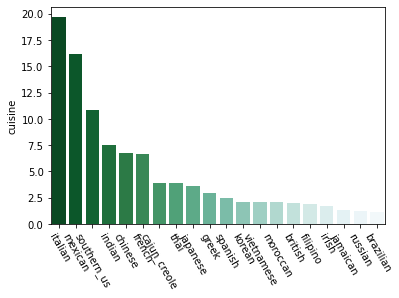

In [28]:
y = data['cuisine'].value_counts()
x = y/y.sum() * 100
y = y.index
fig = sns.barplot(y, x, data=data, palette="BuGn_r")
plt.xticks(rotation=-60)
fig.figure.savefig('barplot.png')
plt.show()

In [29]:
n = 6714 # total ingredients
frame= pd.DataFrame(Counter([i for sublist in data.ingredients for i in sublist]).most_common(n))
frame = frame.head(10)
frame

,0,1
0,salt,18049
1,onions,7972
2,olive oil,7972
3,water,7457
4,garlic,7380
5,sugar,6434
6,garlic cloves,6237
7,butter,4848
8,ground black pepper,4785
9,all-purpose flour,4632


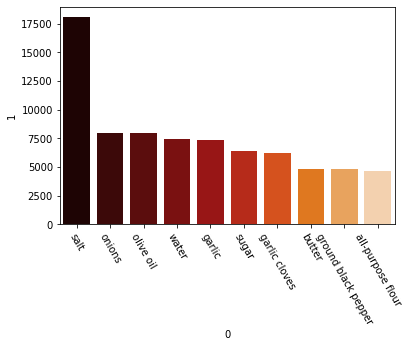

In [30]:
fig = sns.barplot(frame[0], frame[1], palette="gist_heat")
plt.xticks(rotation=-60)
fig.figure.savefig('pop_ingr.png')
plt.show()